In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import scipy.special as special
import scipy.stats as stats
import arviz as az
import seaborn as sns
import pymc3 as pm
import matplotlib.pyplot as plt
import pandas_profiling

import patsy
import statsmodels.formula.api as smf

warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
print(f"pymc3 version: v{pm.__version__}")
print(f"arviz version: v{az.__version__}")

%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")

pymc3 version: v3.11.2
arviz version: v0.11.2


In [2]:
datadir = '/home/telescreen/Workspace/fun/pymc-devs-resources/Rethinking_2/Data/'

In [3]:
brains = pd.DataFrame.from_dict(
    {
        "species": [
            "afarensis",
            "africanus",
            "habilis",
            "boisei",
            "rudolfensis",
            "ergaster",
            "sapiens",
        ],
        "brain": [438, 452, 612, 521, 752, 871, 1350],  # volume in cc
        "mass": [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5],  # mass in kg
    }
)

brains

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


In [4]:
def normalize(series): return (series - series.mean()) / series.std()

In [5]:
brains['brain_std'] = brains['brain'] / brains['brain'].max()
brains['mass_std'] = normalize(brains['mass'])

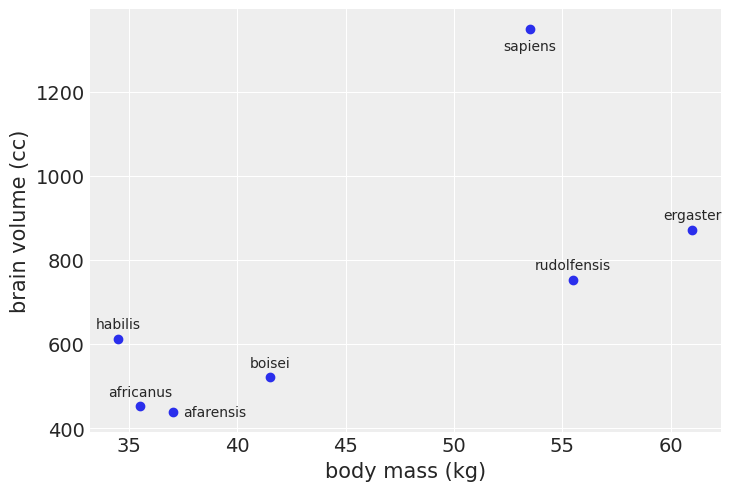

In [6]:
plt.scatter(brains.mass, brains.brain)

# point labels
for i, r in brains.iterrows():
    if r.species == "afarensis":
        plt.text(r.mass + 0.5, r.brain, r.species, ha="left", va="center")
    elif r.species == "sapiens":
        plt.text(r.mass, r.brain - 25, r.species, ha="center", va="top")
    else:
        plt.text(r.mass, r.brain + 25, r.species, ha="center")

plt.xlabel("body mass (kg)")
plt.ylabel("brain volume (cc)");

In [7]:
m7_1 = smf.ols('brain_std ~ mass_std', data=brains)
r7_1 = m7_1.fit()
r7_1.summary()

/home/telescreen/Softwares/miniconda3/envs/kaggle/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              brain_std   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     4.807
Date:                Sun, 24 Oct 2021   Prob (F-statistic):             0.0798
Time:                        16:45:39   Log-Likelihood:                 2.9925
No. Observations:                   7   AIC:                            -1.985
Df Residuals:                       5   BIC:                            -2.093
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5287      0.071      7.492      0.001       0.347       0.710
mass_std       0.1671      0.076      2.192      0.080      -0.029       0.363
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.561
Prob(Omnibus):                    nan   Jarque-Bera (JB):                2.372
Skew:                           1.399   Prob(JB):                        0.305
Kurtosis:                       3.548   Cond. No.                         1.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
1 - r7_1.resid.var() / brains.brain_std.var()

0.49015804794908413

In [9]:
m7_1 = smf.ols('brain_std ~ mass_std', data=brains).fit()
m7_2 = smf.ols('brain_std ~ mass_std + I(mass_std**2)', data=brains).fit()
m7_3 = smf.ols('brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3)', data=brains).fit()
m7_4 = smf.ols('brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4)', data=brains).fit()
m7_5 = smf.ols('brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4) + I(mass_std**5)', data=brains).fit()
m7_6 = smf.ols('brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4) + I(mass_std**5) + I(mass_std**6)', data=brains).fit()

/home/telescreen/Softwares/miniconda3/envs/kaggle/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


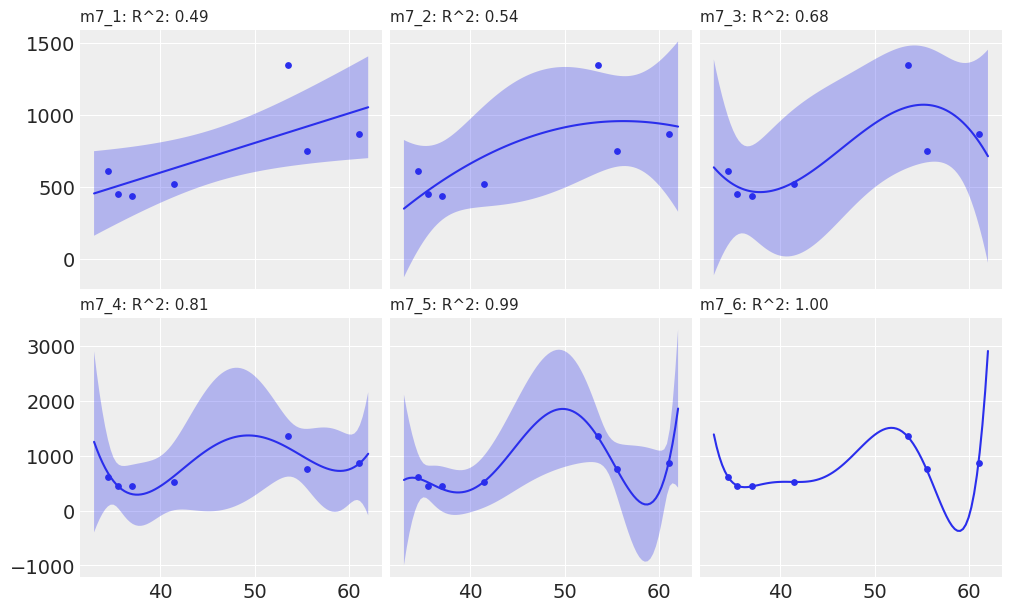

In [10]:
models = [m7_1, m7_2, m7_3, m7_4, m7_5, m7_6]
names = ['m7_1', 'm7_2', 'm7_3', 'm7_4', 'm7_5', 'm7_6']

mass_plot = np.linspace(33, 62, 100)
mass_new = (mass_plot - brains['mass'].mean()) / brains['mass'].std()

fig, axes = plt.subplots(2, 3, figsize=(10,6), sharex=True, sharey='row')
for m, name, ax in zip(models, names, axes.flat):
    prediction = m.get_prediction({'mass_std': mass_new})
    pred = prediction.summary_frame(alpha=0.11) * brains.brain.max()
    
    ax.plot(mass_plot, pred['mean'])
    ax.fill_between(mass_plot, pred['mean_ci_lower'], pred['mean_ci_upper'], alpha=0.3)
    ax.scatter(brains.mass, brains.brain, color='C0', s=15)
    ax.set_title(f"{name}: R^2: {m.rsquared:.2f}", loc="left", fontsize=11)

In [11]:
np.sum(special.rel_entr([0.7, 0.3], [0.01, 0.99]))

2.615769928892821

In [12]:
np.sum(special.rel_entr([0.01, 0.99], [0.7, 0.3]))

1.1394982913672167

In [44]:
list(map(lambda m: np.sum(lppd(m, nsamples=1000)), [m7_1, m7_2, m7_3, m7_4, m7_5]))

[2.550797009933386,
 2.3146200375773285,
 2.8306400058180667,
 3.4904206622684137,
 11.083232123936892]

In [1]:
def lppd(model, nsamples=10000):
    pars = stats.multivariate_normal(model.params, model.cov_params()).rvs(nsamples).T
    dmat = patsy.dmatrix(model.model.data.design_info, brains, return_type='dataframe').values
    pred = dmat.dot(pars)    
    n, ns = pred.shape
    sigmas = (np.sum((pred - brains.brain_std.values.reshape(-1, 1))**2, 0) / 7)**0.5
    ll = stats.norm.logpdf(np.repeat(brains.brain_std.values.reshape(-1,1), ns, axis=1), pred, sigmas)
    lppd = special.logsumexp(ll, axis=1) - np.log(ns)
    return lppd

In [45]:
lppd(m7_1)

array([ 0.61962065,  0.65716931,  0.55379495,  0.62775522,  0.47600475,
        0.44438645, -0.85023504])

In [16]:
cars = pd.read_csv(os.path.join(datadir, 'cars.csv'), delimiter=',', index_col=0)

In [17]:
with pm.Model() as m:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 10)
    mu = a + b*cars.speed
    sigma = pm.Exponential('sigma', 1)
    dist = pm.Normal('dist', mu, sigma, observed=cars.dist)
    trace = pm.sample(2000, tune=15000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 15_000 tune and 2_000 draw iterations (60_000 + 8_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8919194557864019, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8837103996402819, but should be close to 0.8. Try to increase the number of tuning steps.


In [35]:
nsamples = 1000
ncases = cars.shape[0]
mu = trace['a'][:nsamples] + trace['b'][:nsamples] * cars.speed.values.reshape(-1, 1)
logprob = np.zeros((ncases, nsamples))
d = np.repeat(cars.dist.values.reshape(-1,1), ns, axis=1)
logprob = stats.norm.logpdf(d, loc=mu[:, :ns], scale=trace['sigma'][:ns])
lppd = special.logsumexp(logprob, axis=1) - np.log(nsamples)
pWAIC = np.var(logprob, axis=1)
-2*(np.sum(lppd) - np.sum(pWAIC))

421.3458914316012

In [33]:
waic_vec = -2*(lppd - pWAIC)
(ncases*np.var(waic_vec))**0.5

16.41017443664349

In [46]:
# number of plants
N = 100
# simulate initial heights
h0 = np.random.normal(10, 2, N)
# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], N / 2)
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4, size=N)
h1 = h0 + np.random.normal(5 - 3 * fungus, size=N)
# compose a clean data frame
d = pd.DataFrame.from_dict({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})

with pm.Model() as m_6_6:
    p = pm.Lognormal("p", 0, 0.25)

    mu = pm.Deterministic("mu", p * d.h0)
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_6_trace = pm.sample(return_inferencedata=True)

with pm.Model() as m_6_7:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)
    bf = pm.Normal("bf", 0, 0.5)

    p = a + bt * d.treatment + bf * d.fungus

    mu = pm.Deterministic("mu", p * d.h0)
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_7_trace = pm.sample(return_inferencedata=True)

with pm.Model() as m_6_8:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)

    p = a + bt * d.treatment

    mu = pm.Deterministic("mu", p * d.h0)
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_8_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bf, bt, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bt, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [48]:
az.waic(m_6_7_trace, m_6_7, scale='deviance')

/home/telescreen/Softwares/miniconda3/envs/kaggle/lib/python3.9/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 by 100 log-likelihood matrix

              Estimate       SE
deviance_waic   331.92    14.49
p_waic            3.83        -

There has been a warning during the calculation. Please check the results.

In [52]:
compare_df = az.compare(
    {
        "m_6_6": m_6_6_trace,
        "m_6_7": m_6_7_trace,
        "m_6_8": m_6_8_trace,
    },
    ic="waic",
    scale="deviance",
)
compare_df

/home/telescreen/Softwares/miniconda3/envs/kaggle/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/telescreen/Softwares/miniconda3/envs/kaggle/lib/python3.9/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_6_7,0,331.921140,3.829464,0.000000,1.000000e+00,14.489489,0.000000,True,deviance
m_6_8,1,395.907402,2.896279,63.986262,0.000000e+00,13.266025,11.975094,False,deviance
m_6_6,2,408.489803,1.679392,76.568664,1.347433e-11,11.697528,14.288797,False,deviance


In [63]:
waic_m6_7 = az.waic(m_6_7_trace, pointwise=True, scale='deviance')
waic_m6_8 = az.waic(m_6_8_trace, pointwise=True, scale='deviance')
diff_waic = waic_m6_7.waic_i - waic_m6_8.waic_i
n = len(waic_m6_7.waic_i)
np.sqrt(n*np.var(diff_waic)).values

/home/telescreen/Softwares/miniconda3/envs/kaggle/lib/python3.9/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


array(11.97509434)

In [68]:
stats.norm.ppf(0.995)

2.5758293035489004

<AxesSubplot:xlabel='Deviance'>

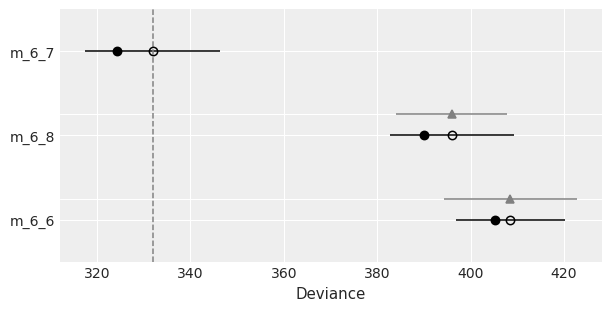

In [71]:
az.plot_compare(compare_df)

In [79]:
divorce = pd.read_csv(os.path.join(datadir, 'WaffleDivorce.csv'), delimiter=';')
divorce['A'] = normalize(divorce.MedianAgeMarriage)
divorce['M'] = normalize(divorce.Marriage)
divorce['D'] = normalize(divorce.Divorce)

In [82]:
with pm.Model() as m5_1:
    intercept = pm.Normal('intercept', 0, 0.2)
    bA = pm.Normal('bA', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = intercept + bA * divorce.A
    D = pm.Normal('D', mu, sigma, observed=divorce.D)
    trace5_1 = pm.sample()

with pm.Model() as m5_2:
    intercept = pm.Normal('intercept', 0, 0.2)
    bM = pm.Normal('bM', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = intercept + bM * divorce.M
    D = pm.Normal('D', mu, sigma, observed=divorce.D)
    trace5_2 = pm.sample()
    
with pm.Model() as m5_3:
    intercept = pm.Normal('intercept', 0, 0.2)
    bA = pm.Normal('bA', 0, 0.5)
    bM = pm.Normal('bM', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = intercept + bM * divorce.M + bA * divorce.A
    D = pm.Normal('D', mu, sigma, observed=divorce.D)
    trace5_3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, bA, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [85]:
compare_df = az.compare(
    {
        'm5_1': trace5_1,
        'm5_2': trace5_2,
        'm5_3': trace5_3,
    },
    ic='loo', 
    scale='deviance'
)
compare_df

/home/telescreen/Softwares/miniconda3/envs/kaggle/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m5_1,0,126.021079,3.807155,0.000000,8.929174e-01,12.921394,0.000000,True,deviance
m5_3,1,127.578328,4.728088,1.557250,4.841663e-16,12.573382,0.891523,False,deviance
m5_2,2,139.534453,3.082671,13.513374,1.070826e-01,9.973780,9.447370,False,deviance


/home/telescreen/Softwares/miniconda3/envs/kaggle/lib/python3.9/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Text(0, 0.5, 'WAIC')

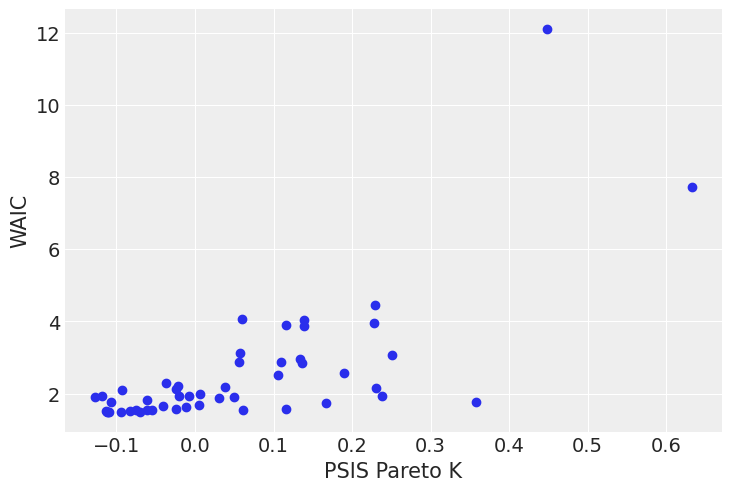

In [88]:
loo5_3 = az.loo(trace5_3, pointwise=True, scale='deviance')
waic5_3 = az.waic(trace5_3, pointwise=True, scale='deviance')
plt.scatter(loo5_3.pareto_k, waic5_3.waic_i)
plt.xlabel('PSIS Pareto K')
plt.ylabel('WAIC')

Text(0.5, 0.98, 'Thin tail and influential observation')

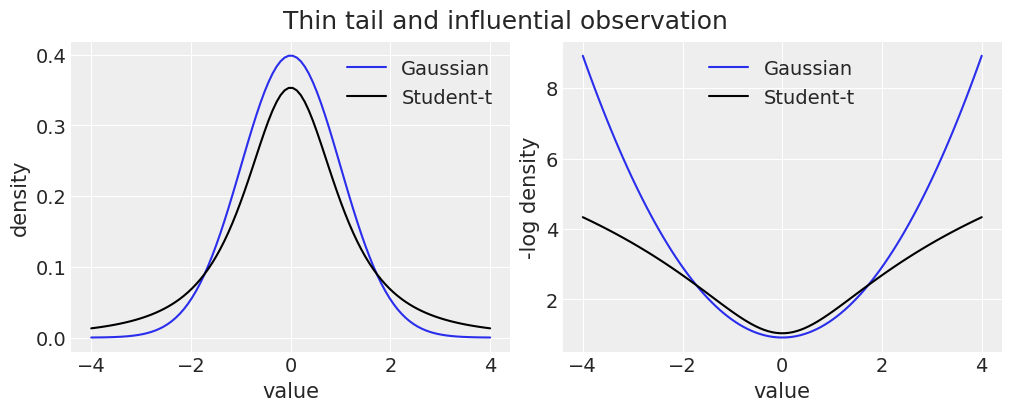

In [116]:
x = np.linspace(-4,4,100)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(x, stats.norm.pdf(x), label='Gaussian')
ax[0].plot(x, stats.t.pdf(x, 2), color='k', label='Student-t')
ax[0].set_xlabel('value')
ax[0].set_ylabel('density')
ax[0].legend()

ax[1].plot(x, -stats.norm.logpdf(x), label='Gaussian')
ax[1].plot(x, -stats.t.logpdf(x, 2), color='k', label='Student-t')
ax[1].set_xlabel('value')
ax[1].set_ylabel('-log density')
ax[1].legend()

plt.suptitle('Thin tail and influential observation', fontsize=18)

In [118]:
with pm.Model() as m5_4:
    intercept = pm.Normal('intercept', 0, 0.2)
    bA = pm.Normal('bA', 0, 0.5)
    bM = pm.Normal('bM', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = intercept + bM * divorce.M + bA * divorce.A
    D = pm.StudentT('D', 2, mu, sigma, observed=divorce.D)
    trace5_4 = pm.sample()
    
az.loo(trace5_4, pointwise=True, scale='deviance')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, bA, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Computed from 4000 by 50 log-likelihood matrix

             Estimate       SE
deviance_loo   132.13    10.64
p_loo            5.26        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       50  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

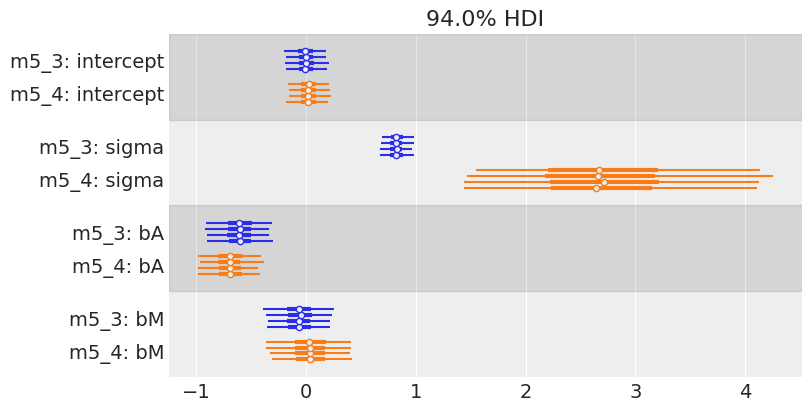

In [120]:
az.plot_forest([trace5_3, trace5_4], model_names=['m5_3', 'm5_4'], figsize=(8, 4))